# Figuring out a good Source Time Function

For doing the reciprocal Green function database, one thing that is required is 
the subsampling the wavefield during simulation. Subsampling requires that the
propagated source does not contain frequencies above the Nyquist frequency. So,
we need to low-pass filter a Heaviside function, or create a Heaviside function
that does not contain high frequencies.

The first, lets look at a butterworth filter to low pass the signal.

## Butterworth lowpass filter

Just to see what we can do, let's create a signal from the sum of 3 sinusoids,
filter and plot it including the filter's frequency response.

The signal here is 5 s long, the sampling rate is at 30 s and contains
the frequencies [1.2, 9, 12] Hz. We create an order 6 butterworth filter with
the cutoff frequency at 3.5 Hz.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
300


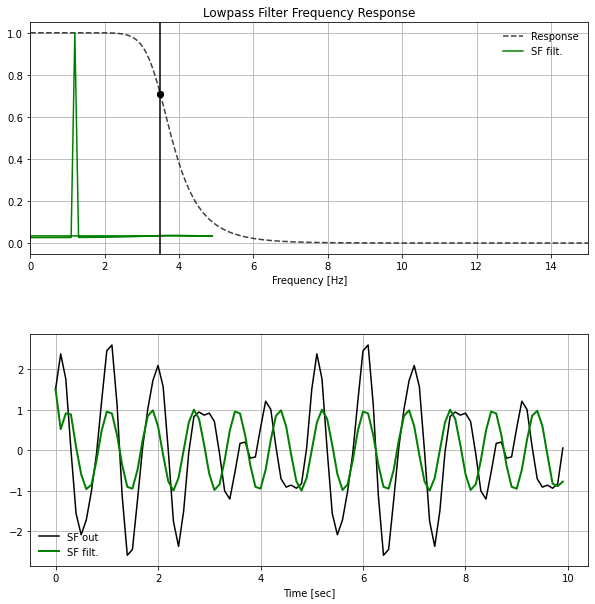

In [24]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from lwsspy.GF.signal.plot import plot_frequency_response
# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 10.0         # seconds
fs = 30.0       # sample rate, Hz
n = int(T * fs)  # total number of samples
print(n)
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + \
    0.5*np.sin(12.0*2*np.pi*t)

# Filter requirements.
order = 6
cutoff = 3.5  # desired cutoff frequency of the filter, Hz
nfs = 10
fig, axes = plot_frequency_response(t, data, cutoff, nfs=nfs, order=6)
fig.savefig('filtertest.pdf')

0.03333333333333333


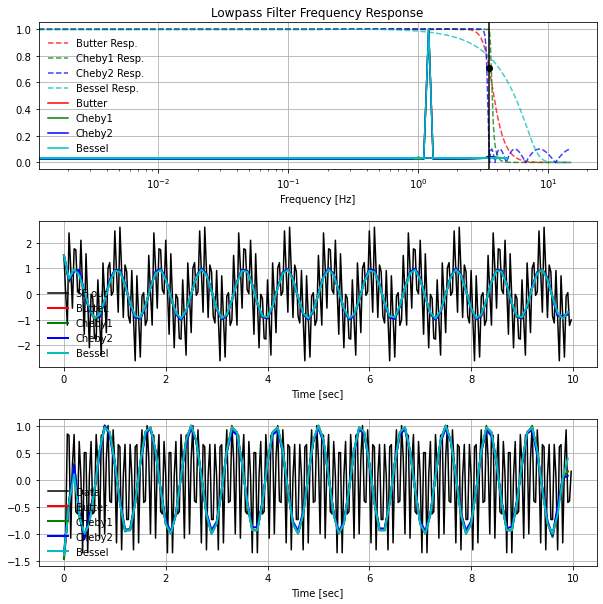

In [25]:
from lwsspy.GF.signal.plot import compare_lowpass_filters

dt = np.diff(t)[0]
print(dt)
cutoff = 3.5
bcutoff = 2*cutoff
rp1 = 0.05
rp2 = 20
border=6
corder=10
bessorder=8
ndt = 1/10

fig, axes = compare_lowpass_filters(t, data, cutoff, bcutoff,ndt=ndt, border=border, corder=corder, bessorder=bessorder, rp1=rp1, rp2=rp2)




## The Specfem output source time function

Next, lets look at a source time function that was created by specfem on the
fly by specifying the halfduration of a Gaussian (the derivative of the) 
heaviside STF.

0.1900000000000004


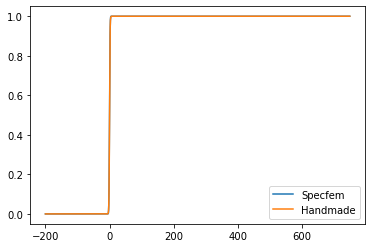

In [93]:
from scipy.interpolate import interp1d

s = np.loadtxt('data/plot_source_time_function.txt').T
# Split into timestamps and STF
t = s[0,:]
s = s[1,:]

# Get sampling rate
dt = np.diff(t)[0]
fs = 1.0/dt

# 
tn = np.arange(5000)*dt - 200
# interpolate to longer t
I = interp1d(t,s,fill_value=(0,1), bounds_error=False)
sn = I(tn)


k = 0.25*(fs)
H = 1.0/(1 + np.exp(-k*tn))

plt.figure()
plt.plot(tn, sn, label='Specfem')
plt.plot(tn, H, label='Handmade')
# plt.xlim(-20,20)
plt.legend()

print(dt)

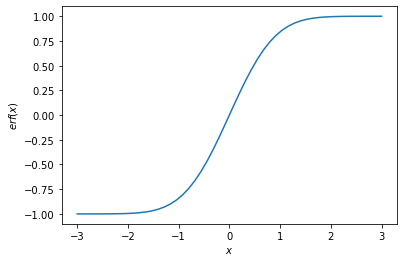

In [90]:
from scipy.fft import fftfreq, fft, next_fast_len
from scipy import special
x = np.linspace(-3, 3)
plt.plot(x, special.erf(x))
plt.xlabel('$x$')
plt.ylabel('$erf(x)$')
plt.show()

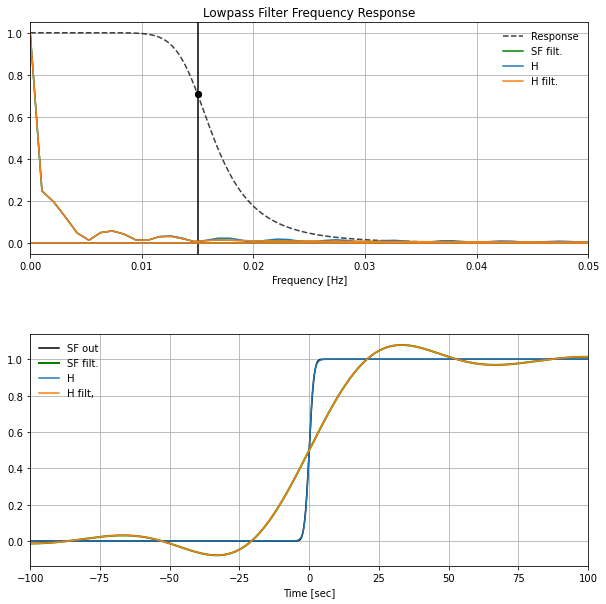

In [91]:
from lwsspy.GF.signal import filter


# k = 0.125*(fs/4)
# H = 1.0/(1 + np.exp(-k*tn))

# H = 0.5*(1+special.erf(np.sqrt(2)*tn/(5*3.1)))

order = 6
cutoff = 0.015
fig, axes = plot_frequency_response(tn, sn, cutoff, order=order)
axes[0].set_xlim(0,0.05)

# Sampling frequency
fs = 1.0/dt

# For FFT
N = len(H)
NFL = next_fast_len(N)

# Associated frequency vector
fvec = fftfreq(len(H), d=dt)

# Get the filter coefficients so we can check its frequency response.
# sos = filter.butter_lowpass(cutoff, fs, order=order)

# Filter the data, and plot both the original and filtered signals.
fH = filter.butter_low_two_pass_filter(H, cutoff, fs, order=order)

# FFT of the data and filtered signals
# Next power of 2 gives very weird results
FH = np.abs(fft(H, n=NFL)[:N])
FfH = np.abs(fft(fH, n=NFL)[:N])


axes[0].plot(fvec, FH/FH.max(), label='H')
axes[0].plot(fvec, FfH/FfH.max(), label='H filt.')
axes[0].legend(frameon=False)

axes[1].plot(tn, H, label='H')
axes[1].plot(tn, fH, label='H filt,')
axes[1].set_xlim(-100,100)
axes[1].legend(frameon=False)

4.0


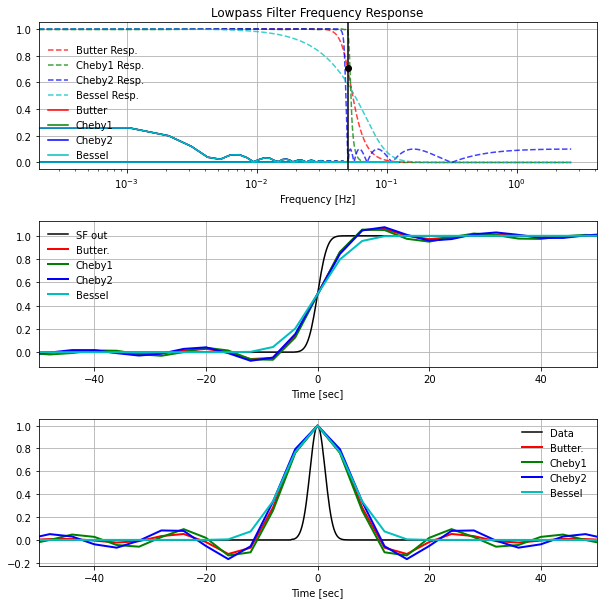

In [92]:
from lwsspy.GF.signal.plot import compare_lowpass_filters

cutoff = 1/20
bcutoff = 1.5*cutoff
rp1 = 0.05
rp2 = 20
border=6
corder=10
bessorder=7
dt = np.diff(t)[0]
ndt = 1/(cutoff*5)
print(ndt)
fig, axes = compare_lowpass_filters(tn, sn, cutoff, bcutoff, ndt, border=border, corder=corder, bessorder=bessorder, rp1=rp1, rp2=rp2)
# axes[0].set_xlim(0,0.05)
axes[0].legend(frameon=False)
axes[1].set_xlim(-50,50)
axes[1].legend(frameon=False)
axes[2].set_xlim(-50,50)
axes[2].legend(frameon=False)